In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sb
import matplotlib.pyplot as plt
import ssl
import requests
from scipy.stats import linregress

In [2]:
attributes = pd.read_csv('attributes.txt')
data = pd.read_csv('communities.data', names=attributes['attributes'])
data.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], inplace=True)

In [3]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [4]:
value_counts_percent = data['LemasPctOfficDrugUn'].value_counts(normalize=True) * 100

# Display the result
print(value_counts_percent)

LemasPctOfficDrugUn
0.00    84.503511
1.00     2.407222
0.51     0.451354
0.36     0.451354
0.61     0.401204
          ...    
0.10     0.050150
0.90     0.050150
0.28     0.050150
0.83     0.050150
0.05     0.050150
Name: proportion, Length: 80, dtype: float64


In [5]:
count_rows_with_question_mark = (data == '?').any(axis=1).sum()
count_rows_with_question_mark

np.int64(1675)

In [6]:
t = 30

'''
LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 
'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 
'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 
'LemasGangUnitDeploy', 'PolicBudgPerPop'
'''
#we remove columns with a high value of unknown values, we set the limit at 30%
question_mark_percentage = (data.isin(['?']).sum() / len(data)) * 100
to_remove = question_mark_percentage[question_mark_percentage > t]
data.drop(columns=to_remove.index.to_list(), inplace=True)

data.replace('?', np.nan, inplace=True)
for i in data.columns:
    data[i] = data[i].astype(float)    
    data[i] = data[i].fillna(data[i].mean())

In [7]:
split_ratio = 0.7
split_index = int(len(data) * split_ratio) 

X = data.drop(columns=['ViolentCrimesPerPop'])
y = data['ViolentCrimesPerPop']

train_X = X.iloc[:split_index]
train_y = y.iloc[:split_index]
test_X = X.iloc[split_index:]
test_y = y.iloc[split_index:]

train_X = np.hstack([np.ones((train_X.shape[0], 1)), train_X])
test_X = np.hstack([np.ones((test_X.shape[0], 1)), test_X])

In [8]:
def split_folds(k, data, seed=42):
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    indexes = data.index.to_numpy()
    fold_sizes = np.array_split(indexes, k)  # Split indexes into k folds based on size
    
    split_indexes = []
    
    for i in range(k):
        test_indexes = fold_sizes[i]
        
        train_indexes = np.concatenate([fold_sizes[j] for j in range(k) if j != i])
        
        split_indexes.append((train_indexes, test_indexes))
        
    return split_indexes

def train_model(X, y):
    all_results = []
    
    for i, (train_indexes, test_indexes) in enumerate(folds):   
        train_X, train_y = X.iloc[train_indexes], y.iloc[train_indexes]
        test_X, test_y = X.iloc[test_indexes], y.iloc[test_indexes]
    
        train_X = np.hstack([np.ones((train_X.shape[0], 1)), train_X])
        test_X = np.hstack([np.ones((test_X.shape[0], 1)), test_X])
    
        betas = np.linalg.inv(train_X.T @ train_X) @ train_X.T @ train_y
        pred_y = test_X @ betas
    
        mae = mean_absolute_error(test_y, pred_y)
        mse = mean_squared_error(test_y, pred_y)
        all_results.append((mae, mse))

    return all_results

k = len(data)
folds = split_folds(k, data)
results = train_model(X,y)

In [9]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [10]:
'''
selected attributes
'PctIlleg', 'HousVacant', 'PctPersDenseHous', 'pctWWage', 'MedOwnCostPctIncNoMtg', 'PctVacantBoarded', 
'racePctWhite', 'PctEmplProfServ', 'PctOccupManu', 'pctWInvInc', 'PctPopUnderPov', 'NumStreet', 
'PctOccupMgmtProf', 'PctYoungKids2Par', 'LemasPctOfficDrugUn', 'racePctAsian', 'MalePctNevMarr', 
'PctRecImmig8', 'PctRecImmig5', 'PctEmplManu', 'PctSameCity85', 'NumInShelters', 'medIncome', 
'MedNumBR', 'PctForeignBorn'

mae= 0.08723123964632121
'''

def forward_feature_selection(train_y, test_y, X):
    values = data.drop(columns=['ViolentCrimesPerPop']).columns.values.tolist()
    split_ratio = 0.7
    '''split_ratio = 0.7
    split_index = int(len(data) * split_ratio) 
    
    train_y = y.iloc[:split_index]
    test_y = y.iloc[split_index:]'''
    
    used_attrs = []
    best_mae = 1
    final = []
    
    while True:
        value_mae = {}
        
        for value in values:    
            if value in used_attrs:
                continue 
                  
            selected_features = used_attrs + [value] 
            
            train_X = X[selected_features].iloc[:split_index].values
            test_X = X[selected_features].iloc[split_index:].values

            train_X = np.hstack([np.ones((train_X.shape[0], 1)), train_X])
            test_X = np.hstack([np.ones((test_X.shape[0], 1)), test_X])
        
            betas = np.linalg.inv(train_X.T @ train_X) @ train_X.T @ train_y
            pred_y = test_X @ betas
        
            value_mae[value] = mean_absolute_error(test_y, pred_y)
        
        new_mae_attr = min(value_mae, key=value_mae.get)
        new_mae = value_mae[new_mae_attr]
        
        if new_mae >= best_mae:
            #used_attrs.pop()
            break
        else:
            best_mae = new_mae
            used_attrs.append(new_mae_attr)
    return used_attrs

used_attrs = forward_feature_selection(train_y, test_y, data)

#print('Current attributes:')
#print(len(used_attrs))
#print(used_attrs)
#print(best_mae)

In [11]:
print(used_attrs)

['PctIlleg', 'PctKids2Par', 'HousVacant', 'racePctWhite', 'agePct12t29', 'MedOwnCostPctIncNoMtg', 'PersPerFam', 'PctEmplManu', 'NumStreet', 'numbUrban', 'PctVacantBoarded', 'pctWInvInc', 'PctOccupMgmtProf', 'pctWFarmSelf', 'LemasPctOfficDrugUn', 'indianPerCap', 'PctFam2Par', 'PersPerOwnOccHous', 'blackPerCap', 'PersPerRentOccHous', 'PersPerOccupHous', 'agePct12t21', 'agePct65up', 'PctHousNoPhone', 'PctImmigRec10', 'PctImmigRec5', 'pctWWage', 'PctImmigRec8', 'NumImmig']


In [12]:
train_subset = X[used_attrs].iloc[:split_index].values
test_subset = X[used_attrs].iloc[split_index:].values

betas = np.linalg.inv(train_subset.T @ train_subset) @ train_subset.T @ train_y
pred_y = test_subset @ betas

mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

print("Results\nMSE = {}\nMAE = {}\nR^2 = {}".format(mse, mae, r2))

Results
MSE = 0.01671140551439879
MAE = 0.09030511746170879
R^2 = 0.6368947258880555


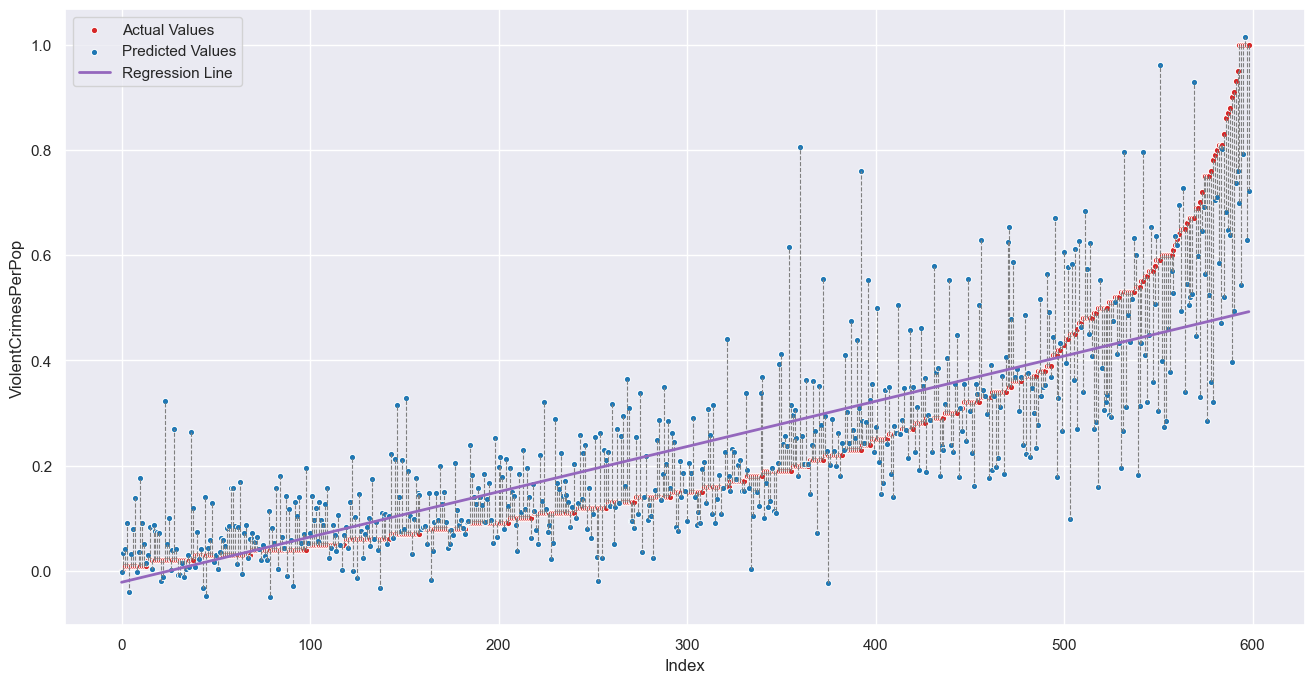

In [13]:
y_test_np = np.array(test_y)
pred_y_np = np.array(pred_y)

print()

sorted_indices = np.argsort(y_test_np)
y_test_np = y_test_np[sorted_indices]
pred_y_np = pred_y_np[sorted_indices]

index = np.arange(len(y_test_np))

sb.set(style="darkgrid")
colors = sb.color_palette(["#1f77b4", "#d62728", "#7f7f7f", "#9467bd"])

plt.figure(figsize=(16, 8))

sb.scatterplot(x=index, y=y_test_np, color=colors[1], s=20, label="Actual Values", edgecolor="w", linewidth=0.7)
sb.scatterplot(x=index, y=pred_y_np, color=colors[0], s=20, label="Predicted Values", edgecolor="w", linewidth=0.7)

for i in range(len(y_test_np)):
    plt.plot([index[i], index[i]], [y_test_np[i], pred_y_np[i]], linestyle="--", color=colors[2], linewidth=0.8)

slope, intercept, _, _, _ = linregress(index, pred_y_np)
regression_line = slope * index + intercept
sb.lineplot(x=index, y=regression_line, color=colors[3], linewidth=2, label="Regression Line")

plt.xlabel("Index")
plt.ylabel("ViolentCrimesPerPop")
plt.legend()
plt.show()

In [14]:
def do_bootstrap(train_X, train_y, test_X, test_y, n_bootstraps=1000, random_state=42):
    np.random.seed(random_state)
    n_samples = len(train_y)
    all_bootstrap_results = []

    for _ in range(n_bootstraps):
        bootstrap_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)

        bootstrap_X, bootstrap_y = train_X[bootstrap_indices], train_y[bootstrap_indices]

        betas = np.linalg.inv(bootstrap_X.T @ bootstrap_X) @ bootstrap_X.T @ bootstrap_y

        pred_y = test_X @ betas
        mae = mean_absolute_error(test_y, pred_y)
        mse = mean_squared_error(test_y, pred_y)
        r2 = r2_score(test_y, pred_y)

        # Append the results
        all_bootstrap_results.append((mae, mse, r2))

    return all_bootstrap_results

all_bootstrap_results_d = do_bootstrap(train_X, train_y, test_X, test_y)

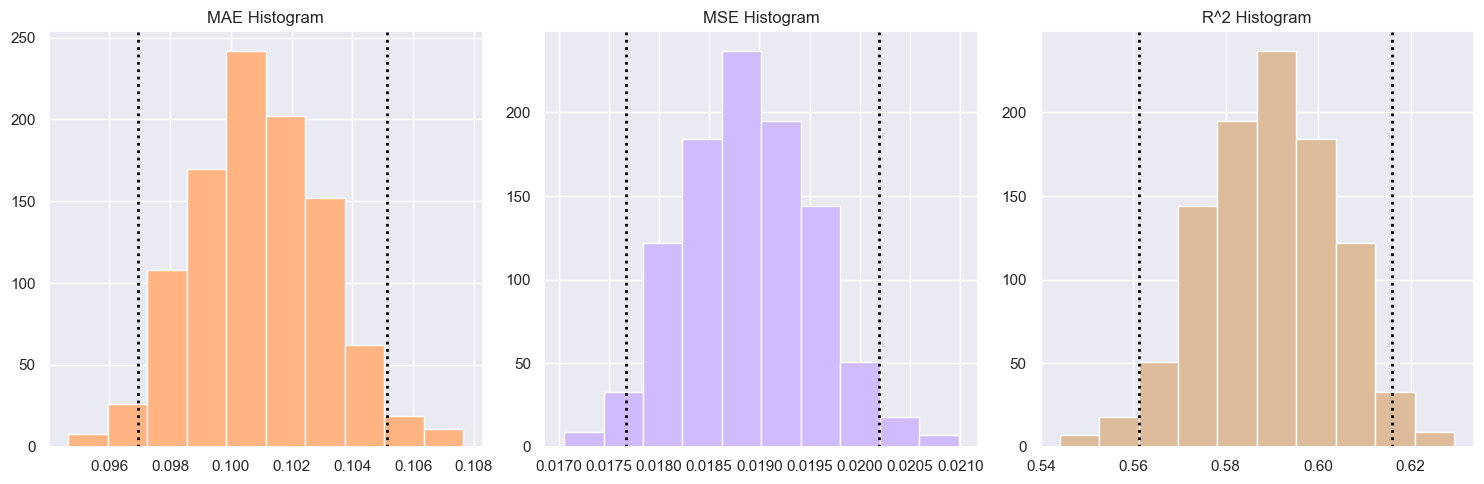

In [15]:
bootstrap_mae_results = [result[0] for result in all_bootstrap_results_d]
bootstrap_mse_results = [result[1] for result in all_bootstrap_results_d]
bootstrap_r2_results = [result[2] for result in all_bootstrap_results_d]

percentiles = [2.5, 97.5]

colors = sb.color_palette("pastel")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(bootstrap_mae_results, color=colors[1])
lower_bound, upper_bound = np.percentile(bootstrap_mae_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('MAE Histogram')

plt.subplot(1, 3, 2)
plt.hist(bootstrap_mse_results, color=colors[4])
lower_bound, upper_bound = np.percentile(bootstrap_mse_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('MSE Histogram')

plt.subplot(1, 3, 3)
plt.hist(bootstrap_r2_results, color=colors[5])
lower_bound, upper_bound = np.percentile(bootstrap_r2_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('R^2 Histogram')

plt.tight_layout()
plt.show()